In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

In [2]:
# import fredkey
fred = Fred(api_key='d59606a150e09c54fd5158bac863da0d') # Jeg skuler min nøkkel her. Skaff din egen.

In [3]:
# requesting data used in the Chauvet paper
series = {
   # name : series id
    'MTS' : 'CMRMTSPL', # manufacturing and trade sales
    'PILTP' : 'W875RX1', # total personal income less transfer payments
    'ENAP' : 'PAYEMS', # employees on nonagricultural payrolls
    'IPMAN' : 'IPMAN' # industrial production
}

def gen_dataset(series: dict):
    lst = []
    for i in series.keys():
        data = fred.get_series(series[i])
        data = data.rename(i)
        lst.append(data)
    
    return pd.concat(lst, axis=1)

df = gen_dataset(series)
df = df.dropna()
df.head()

,MTS,PILTP,ENAP,IPMAN
1972-01-01,436061.565,4208.2,72441.0,35.9488
1972-02-01,431354.862,4231.9,72648.0,36.2194
1972-03-01,439346.765,4259.5,72944.0,36.4664
1972-04-01,442331.562,4273.3,73162.0,36.8786
1972-05-01,445055.610,4291.2,73469.0,36.9454


In [4]:
recession = fred.get_series('USRECDM')
recession.head()

1854-12-01    1.0
1854-12-02    1.0
1854-12-03    1.0
1854-12-04    1.0
1854-12-05    1.0
dtype: float64

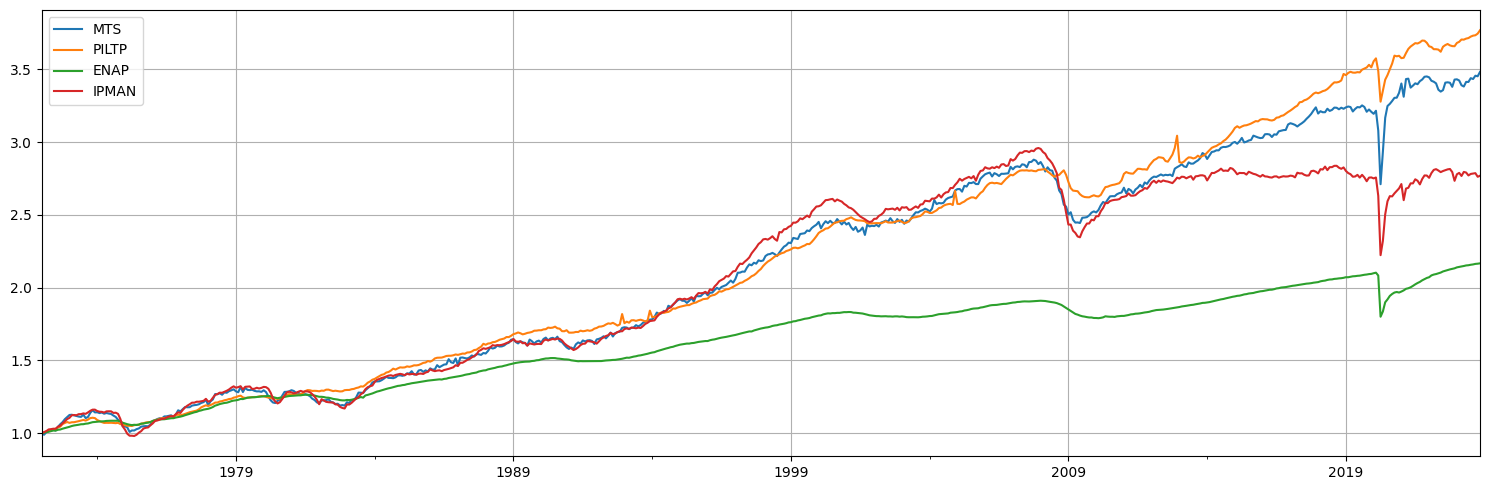

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))

(df / df.iloc[0]).plot(ax=ax)

recession_period = recession.loc[recession.index.isin(df.index)]
# ax.fill_between(df.index, df.min().min(), df.max().max(), where=recession_period.values, color="k", alpha=0.3)

plt.grid()
plt.tight_layout()
plt.show()


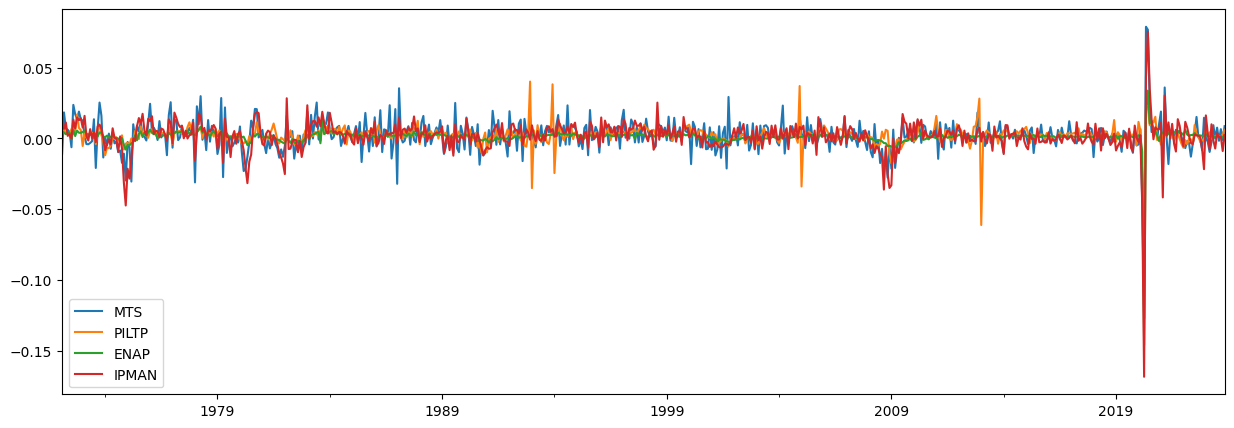

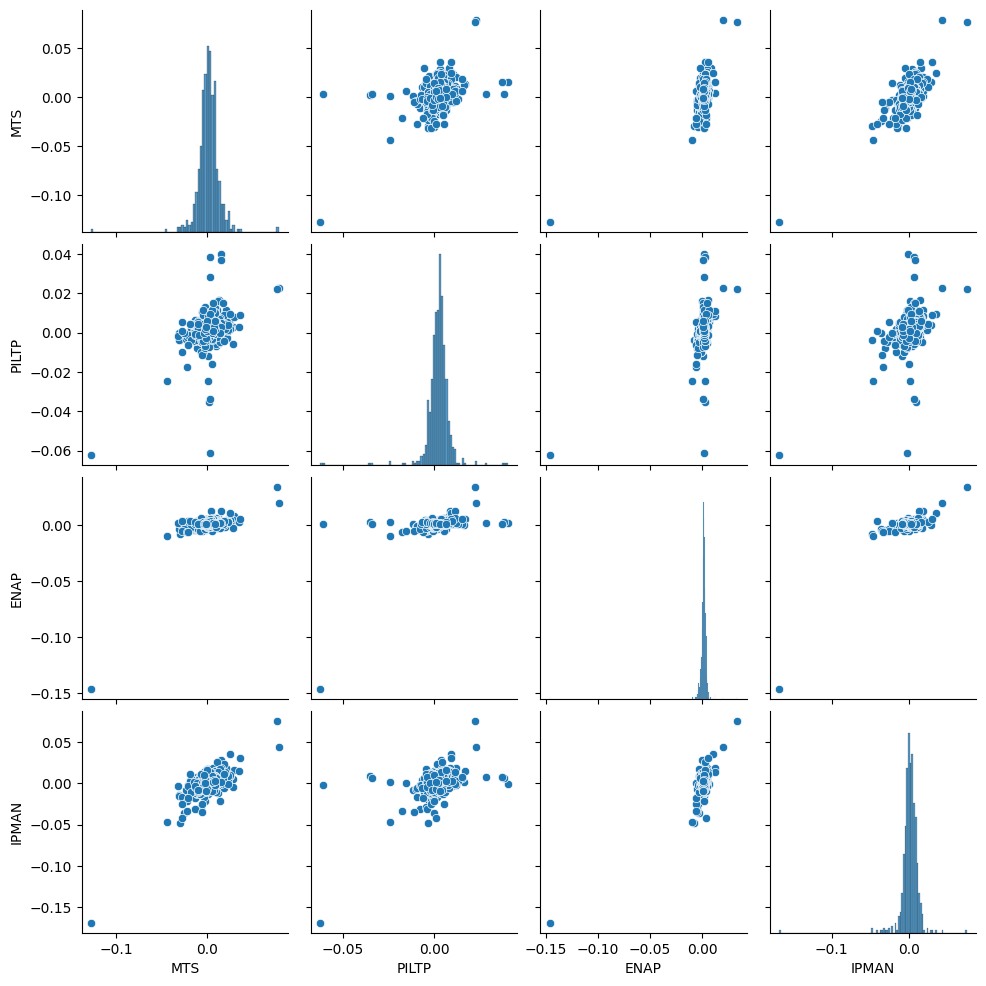

In [6]:
df2 = df.apply(lambda x: np.log(x))
df2 = df2.diff()
df2 = df2.dropna()
df2.plot(figsize=(15,5))
plt.show()

import seaborn as sns
sns.pairplot(df2)
plt.show()

# Factor model without switching

In [7]:
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
dfm = DynamicFactor(
    df2, 
                                      k_factors=3, 
                                      factor_order=2, 
                                      error_order=2,
                                      error_var=False,
                                      enforce_stationarity=False
                                      )

res = dfm.fit(maxiter=500)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           42     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.78788D+00    |proj g|=  2.47747D+01


 This problem is unconstrained.



At iterate    5    f= -8.22184D+00    |proj g|=  2.49605D+01

At iterate   10    f= -1.01041D+01    |proj g|=  1.90299D+02

At iterate   15    f= -1.13583D+01    |proj g|=  4.06662D+01

At iterate   20    f= -1.15862D+01    |proj g|=  1.47939D+01

At iterate   25    f= -1.15955D+01    |proj g|=  4.15565D+00

At iterate   30    f= -1.16340D+01    |proj g|=  1.70667D+01

At iterate   35    f= -1.16660D+01    |proj g|=  2.84772D+01

At iterate   40    f= -1.17147D+01    |proj g|=  1.75251D+01

At iterate   45    f= -1.17406D+01    |proj g|=  1.45077D+01

At iterate   50    f= -1.17923D+01    |proj g|=  2.15474D+01

At iterate   55    f= -1.19686D+01    |proj g|=  3.26007D+01

At iterate   60    f= -1.24004D+01    |proj g|=  3.07188D+01

At iterate   65    f= -1.26171D+01    |proj g|=  1.98467D+01

At iterate   70    f= -1.30406D+01    |proj g|=  3.77710D+01

At iterate   75    f= -1.35309D+01    |proj g|=  4.23577D+01

At iterate   80    f= -1.40678D+01    |proj g|=  2.96545D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [8]:
print(res.summary())

                                   Statespace Model Results                                  
Dep. Variable:     ['MTS', 'PILTP', 'ENAP', 'IPMAN']   No. Observations:                  622
Model:             DynamicFactor(factors=3, order=2)   Log Likelihood                8920.600
                                      + AR(2) errors   AIC                         -17757.200
Date:                               Fri, 02 Feb 2024   BIC                         -17571.017
Time:                                       13:12:22   HQIC                        -17684.840
Sample:                                   02-01-1972                                         
                                        - 11-01-2023                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):     1.58, 1.57, 1.15, 0.02   Jarque-Bera (JB):   18641.27, 15918.88, 1004531.21, 390.57
Prob(Q):                0.21, 0.21, 0.28, 0.90

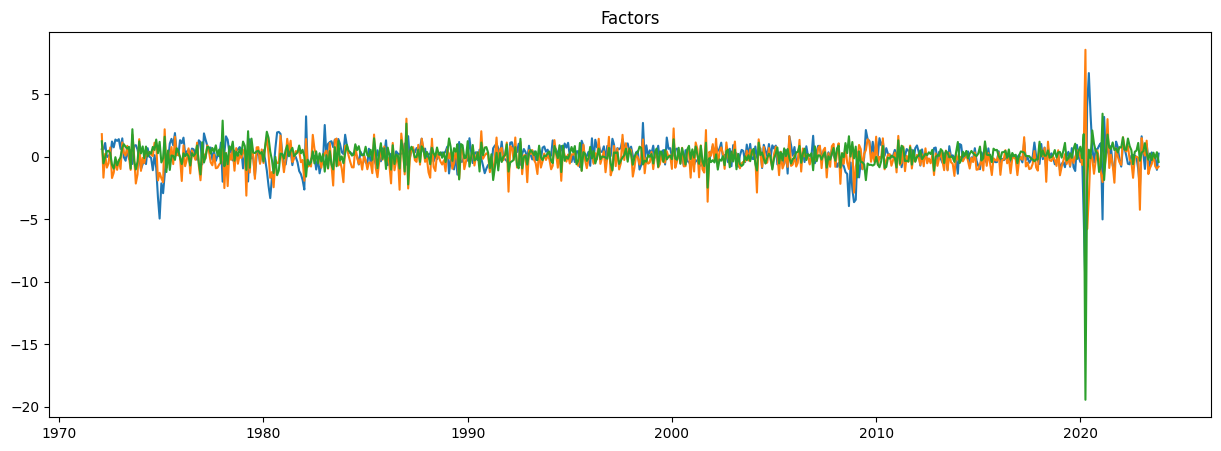

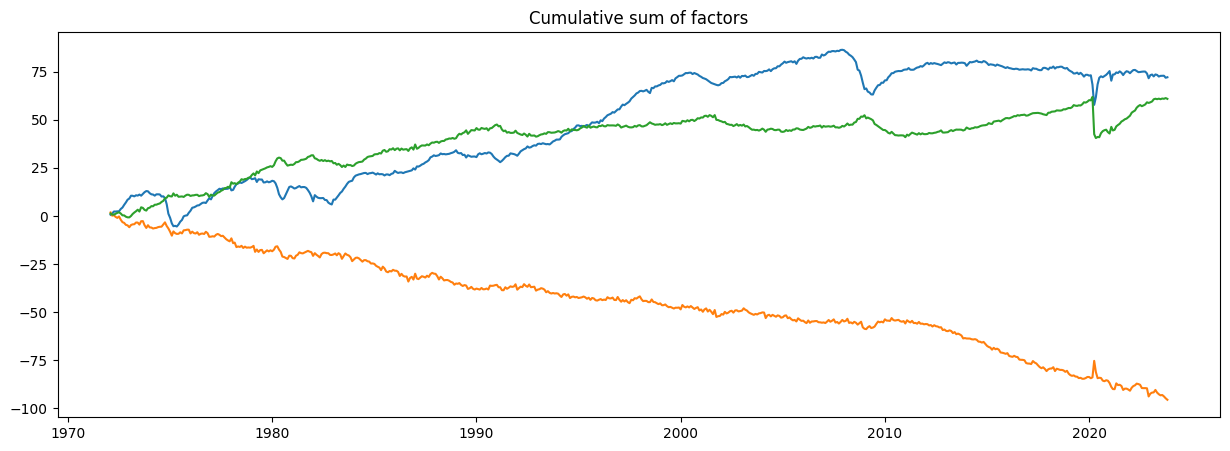

In [9]:
plt.figure(figsize=(15,5))
for i in range(res.factors['filtered'].shape[0]):
    plt.plot(df2.index, res.factors['filtered'][i])
plt.title('Factors')
plt.show()

plt.figure(figsize=(15,5))
for i in range(res.factors['filtered'].shape[0]):
    plt.plot(df2.index, np.cumsum(res.factors['filtered'][i]))
plt.title('Cumulative sum of factors')
plt.show()

## More variables

In [12]:
ext_series = {
   # name : series id
    'MTS' : 'CMRMTSPL', # manufacturing and trade sales
    'PILTP' : 'W875RX1', # total personal income less transfer payments
    'ENAP' : 'PAYEMS', # employees on nonagricultural payrolls
    'IPMAN' : 'IPMAN', # industrial production
    'UNRATE' : 'UNRATE', # Unemployment Rate 
    'LOANS' : 'LOANS', # Loans and Leases in Bank Credit, All Commercial Banks
    '1y_yield' : 'DGS1', # Market Yield on U.S. Treasury Securities at 1-Year Constant
    '10y_yield' : 'DGS10', # Market Yield on U.S. Treasury Securities at 10-Year Constant
    'PCE' : 'PCE', # Personal Consumption Expenditures
    # 'stocks' : 'M1109BUSM293NNBR', # Share Prices: All Shares/Broad: Total for United
    'ind_loans' : 'BUSLOANS', # Commercial and Industrial Loans, All Commercial Banks
}

df3 = gen_dataset(ext_series)
df3 = df3.dropna()
df3

,MTS,PILTP,ENAP,IPMAN,UNRATE,LOANS,1y_yield,10y_yield,PCE,ind_loans
1972-02-01,431354.862,4231.9,72648.0,36.2194,5.7,345.5777,4.44,6.09,736.2,118.8982
1972-03-01,439346.765,4259.5,72944.0,36.4664,5.8,350.7484,4.28,6.04,749.2,119.6910
1972-05-01,445055.610,4291.2,73469.0,36.9454,5.7,361.4069,4.57,6.14,758.0,122.6920
1972-06-01,446997.410,4304.2,73758.0,37.0530,5.7,366.7187,4.72,6.07,761.6,123.7672
1972-08-01,454870.354,4375.5,74141.0,37.5429,5.6,375.2258,4.83,6.14,776.3,126.0083
...,...,...,...,...,...,...,...,...,...,...
2023-05-01,1489005.000,15622.4,155970.0,100.3586,3.7,12117.3747,4.86,3.59,18407.8,2769.2335
2023-06-01,1488903.000,15638.0,156075.0,99.6427,3.6,12110.9306,5.11,3.61,18485.4,2764.0889
2023-08-01,1497717.000,15707.7,156476.0,100.0939,3.8,12182.1346,5.38,4.05,18651.6,2764.0963
2023-09-01,1507530.000,15719.1,156738.0,100.2040,3.8,12214.2044,5.36,4.18,18791.5,2765.4185


<Axes: >

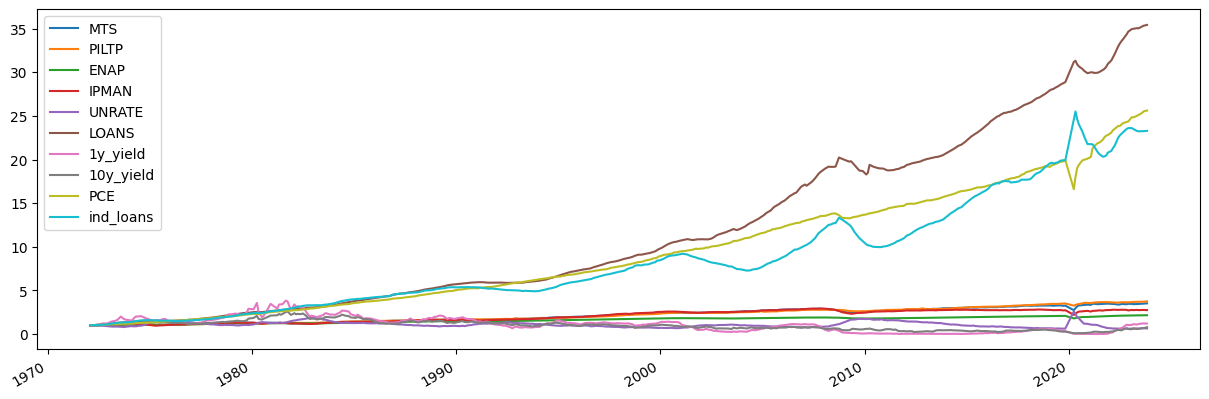

In [13]:
(df3/df3.iloc[0]).plot(figsize=(15,5))

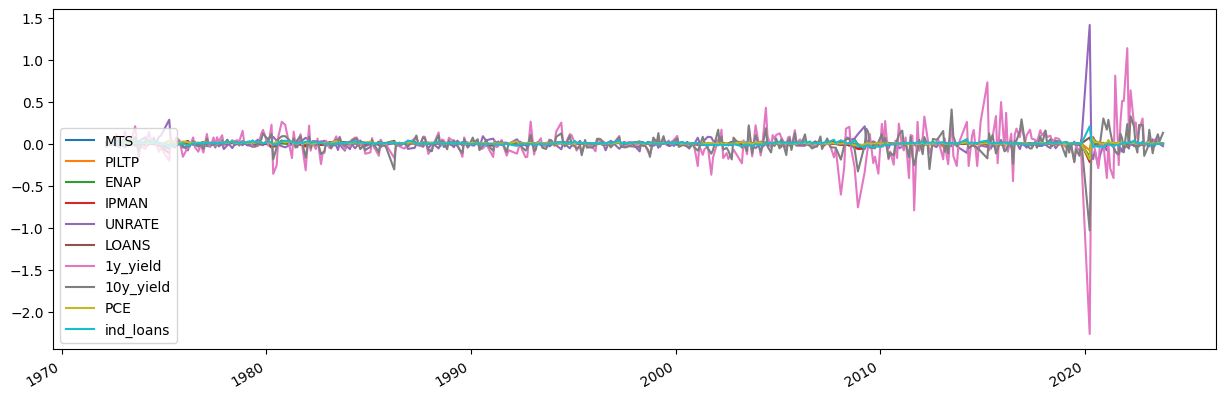

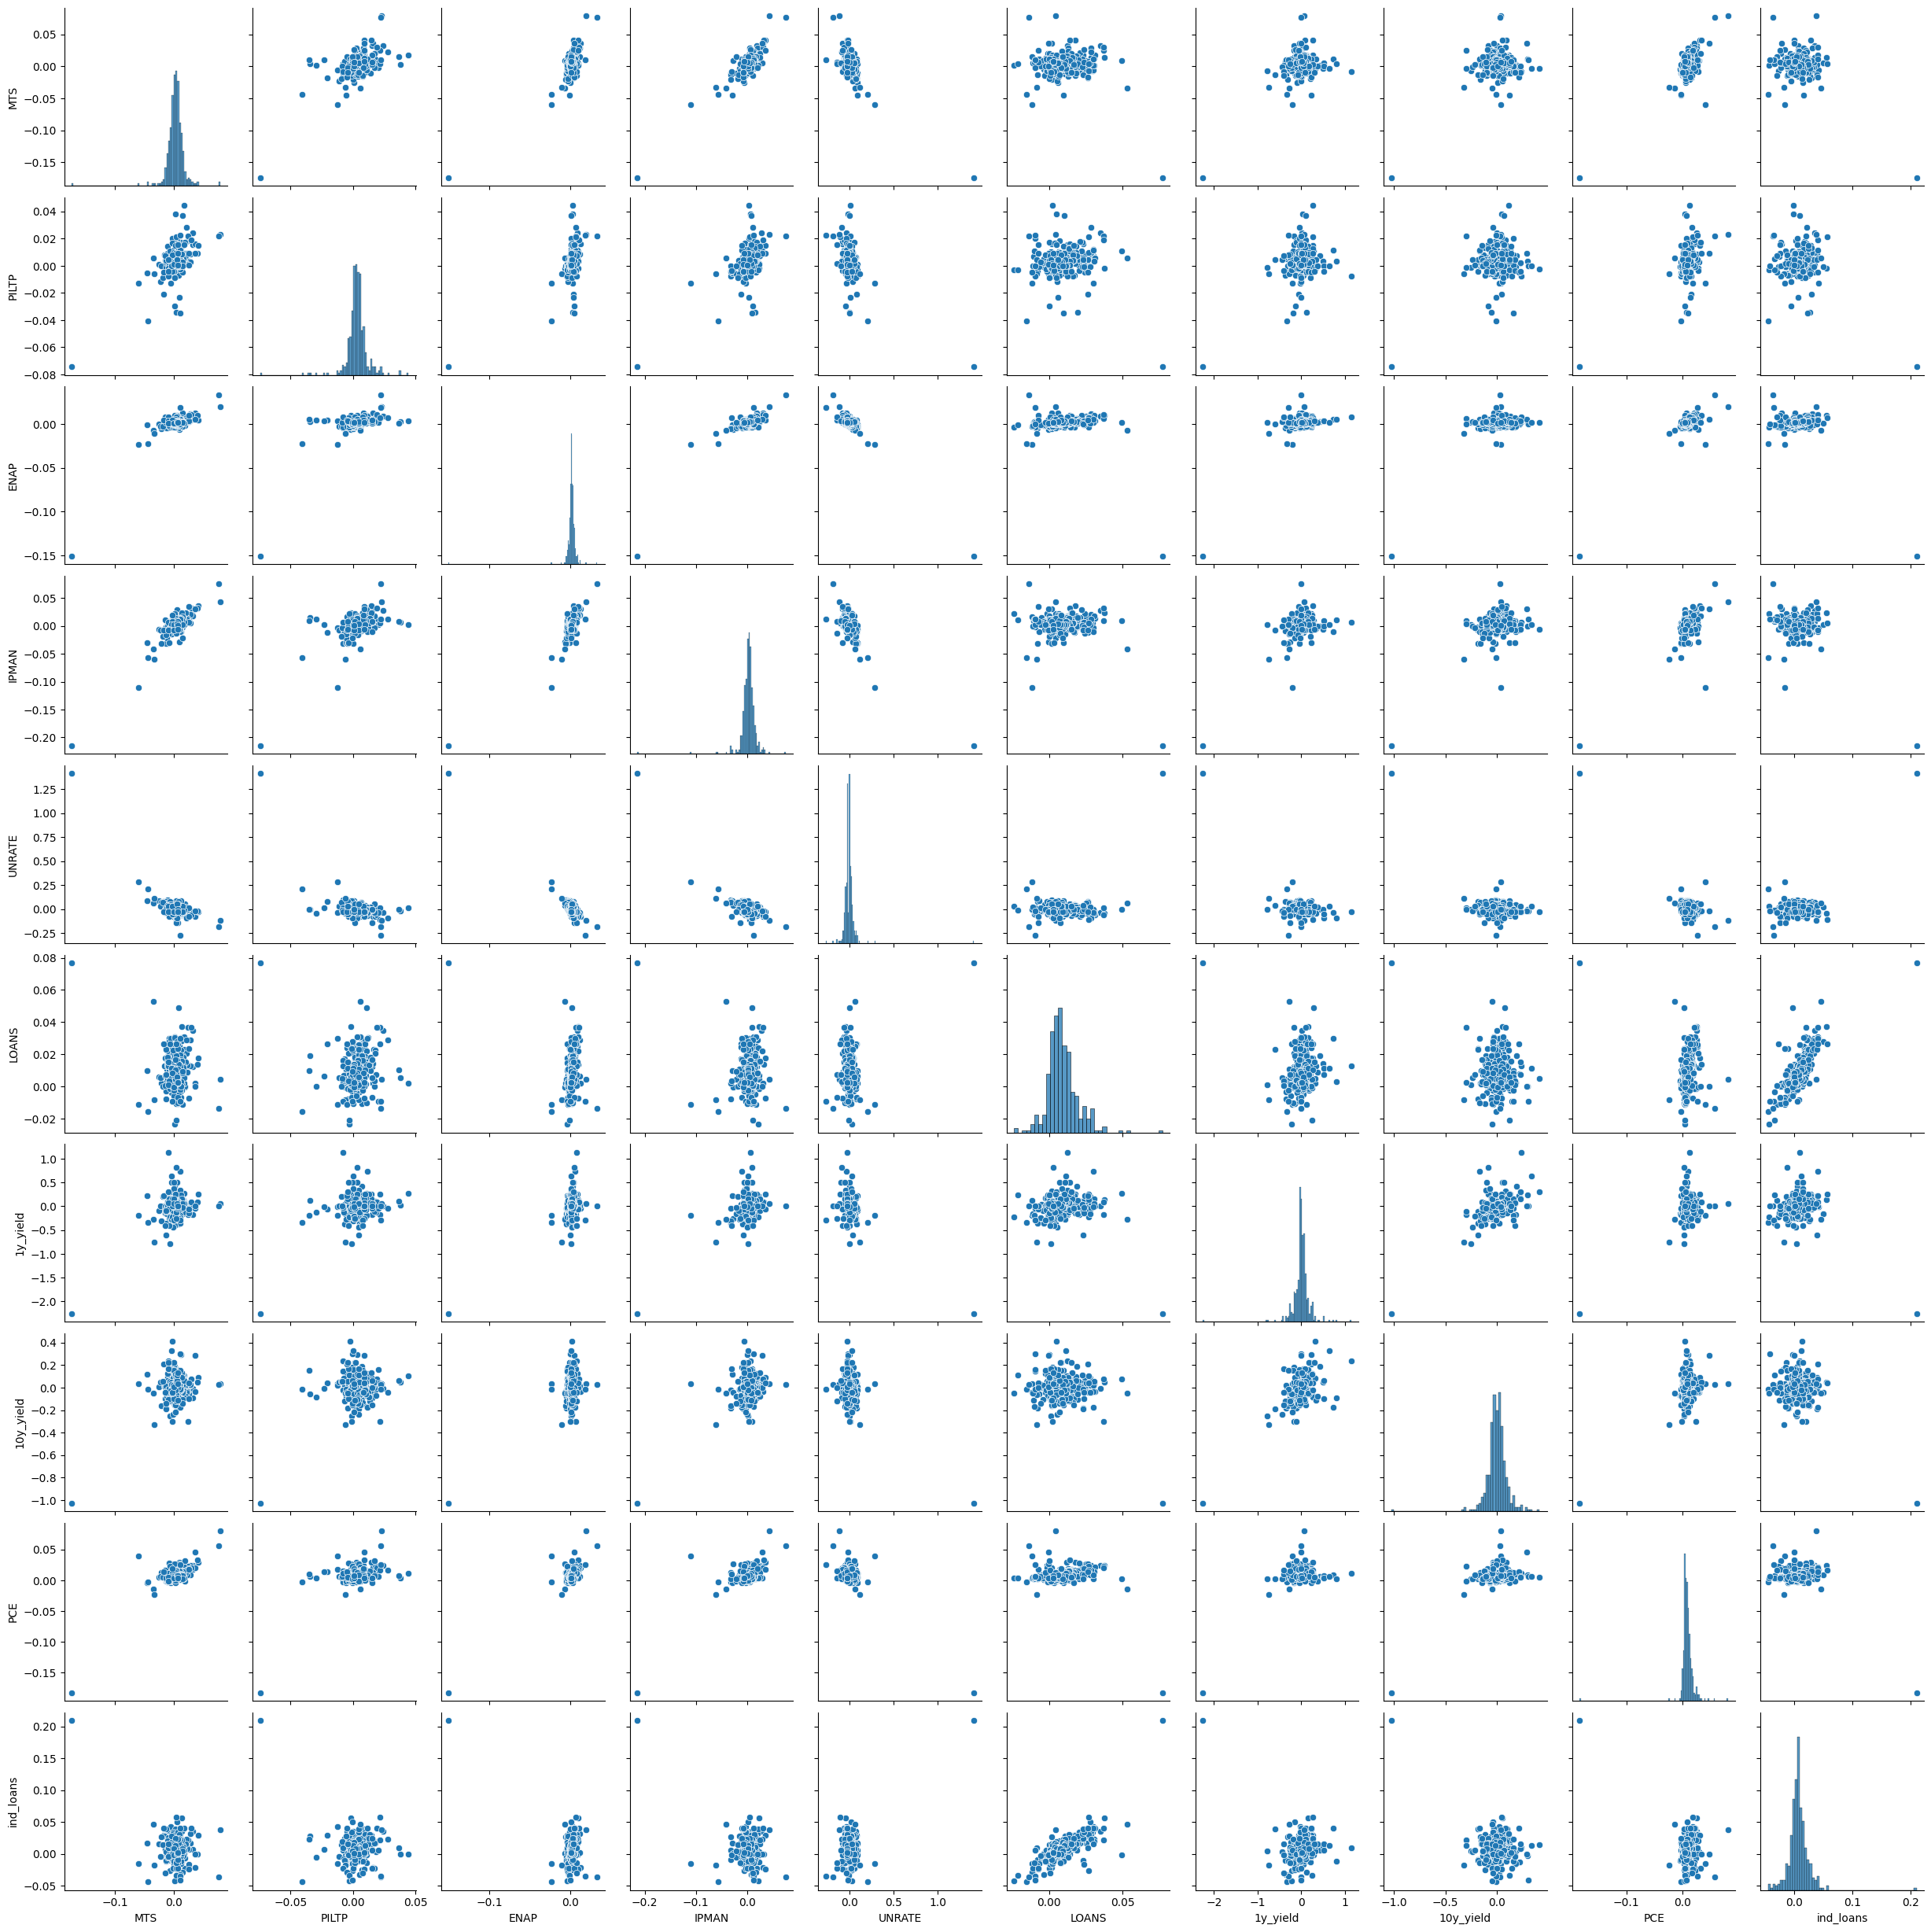

In [14]:
df4 = df3.apply(lambda x: np.log(x))
df4 = df4.diff()
df4 = df4.dropna()
df4.plot(figsize=(15,5))
plt.show()

import seaborn as sns
sns.pairplot(df4)
plt.show()

In [29]:
dfm2 = DynamicFactor(
    df4, 
                                      k_factors=2, 
                                      factor_order=2, 
                                      error_order=2,
                                      error_var=False,
                                      enforce_stationarity=False
                                      )

res2 = dfm2.fit(maxiter=500)

/Users/williamsoma/miniconda3/envs/jobb/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           58     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.90041D+01    |proj g|=  6.87805D+01


 This problem is unconstrained.



At iterate    5    f= -2.07486D+01    |proj g|=  3.21697D+02

At iterate   10    f= -2.12964D+01    |proj g|=  1.11427D+01

At iterate   15    f= -2.15601D+01    |proj g|=  1.42707D+01

At iterate   20    f= -2.16071D+01    |proj g|=  1.34213D+01

At iterate   25    f= -2.16651D+01    |proj g|=  2.20233D+01

At iterate   30    f= -2.17256D+01    |proj g|=  2.40719D+01

At iterate   35    f= -2.18673D+01    |proj g|=  2.35273D+01

At iterate   40    f= -2.20451D+01    |proj g|=  3.29019D+01

At iterate   45    f= -2.21296D+01    |proj g|=  1.14788D+01

At iterate   50    f= -2.22350D+01    |proj g|=  3.67173D+01

At iterate   55    f= -2.25702D+01    |proj g|=  1.93736D+01

At iterate   60    f= -2.26372D+01    |proj g|=  1.29078D+01

At iterate   65    f= -2.27474D+01    |proj g|=  6.94778D+00

At iterate   70    f= -2.28354D+01    |proj g|=  1.13682D+01

At iterate   75    f= -2.28795D+01    |proj g|=  9.80398D+00

At iterate   80    f= -2.29465D+01    |proj g|=  7.28752D+00

At iter

/Users/williamsoma/miniconda3/envs/jobb/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   58    217    255      1     0     0   4.211D+00  -2.436D+01
  F =  -24.358291082605703     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


In [30]:
print(res2.summary())

                                                                   Statespace Model Results                                                                  
Dep. Variable:     ['MTS', 'PILTP', 'ENAP', 'IPMAN', 'UNRATE', 'LOANS', '1y_yield', '10y_yield', 'PCE', 'ind_loans']   No. Observations:                  397
Model:                                                                             DynamicFactor(factors=2, order=2)   Log Likelihood                9670.242
                                                                                                      + AR(2) errors   AIC                         -19224.483
Date:                                                                                               Fri, 02 Feb 2024   BIC                         -18993.415
Time:                                                                                                       13:25:05   HQIC                        -19132.950
Sample:                                             

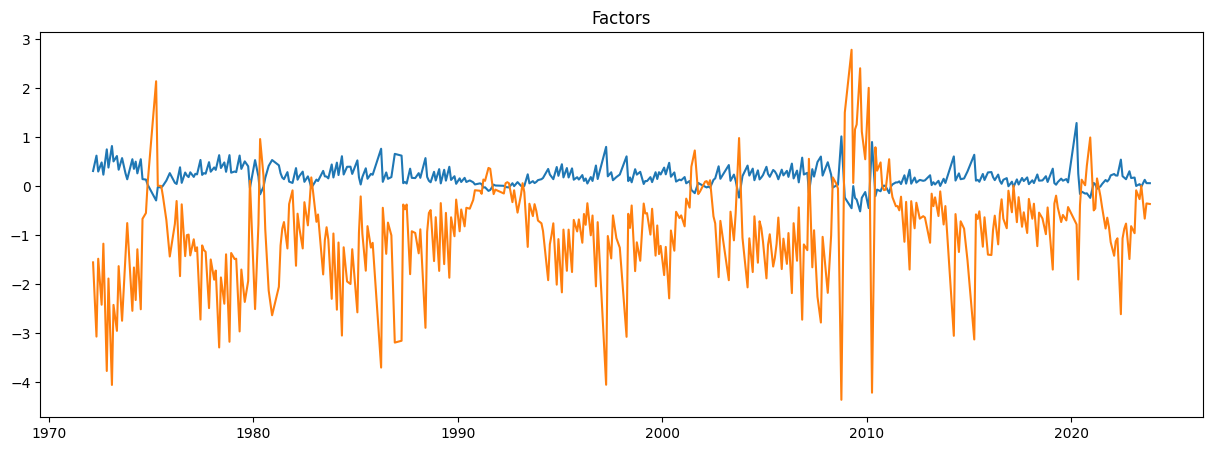

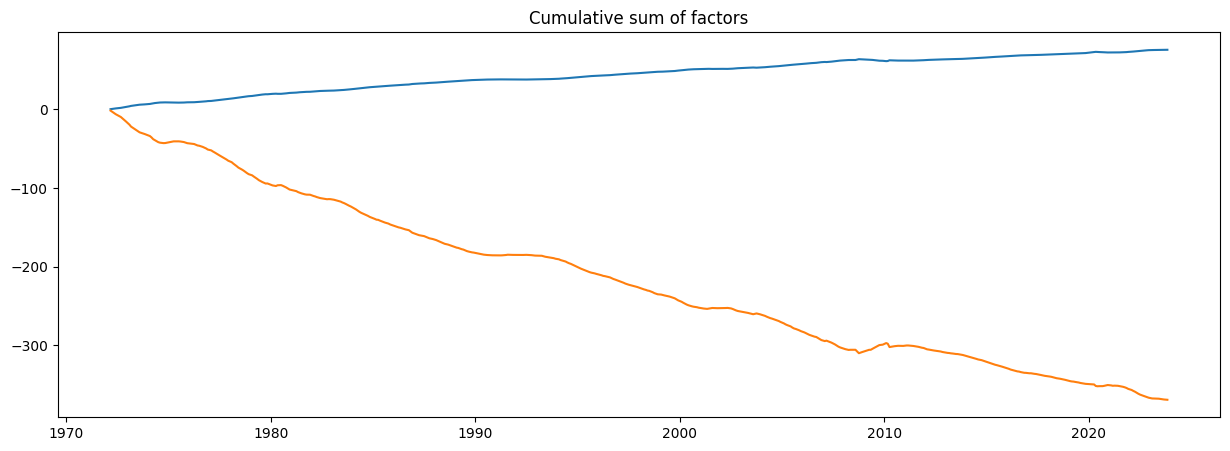

In [31]:
plt.figure(figsize=(15,5))
for i in range(res2.factors['filtered'].shape[0]):
    plt.plot(df4.index, res2.factors['filtered'][i])
plt.title('Factors')
plt.show()

plt.figure(figsize=(15,5))
for i in range(res2.factors['filtered'].shape[0]):
    plt.plot(df4.index, np.cumsum(res2.factors['filtered'][i]))
plt.title('Cumulative sum of factors')
plt.show()

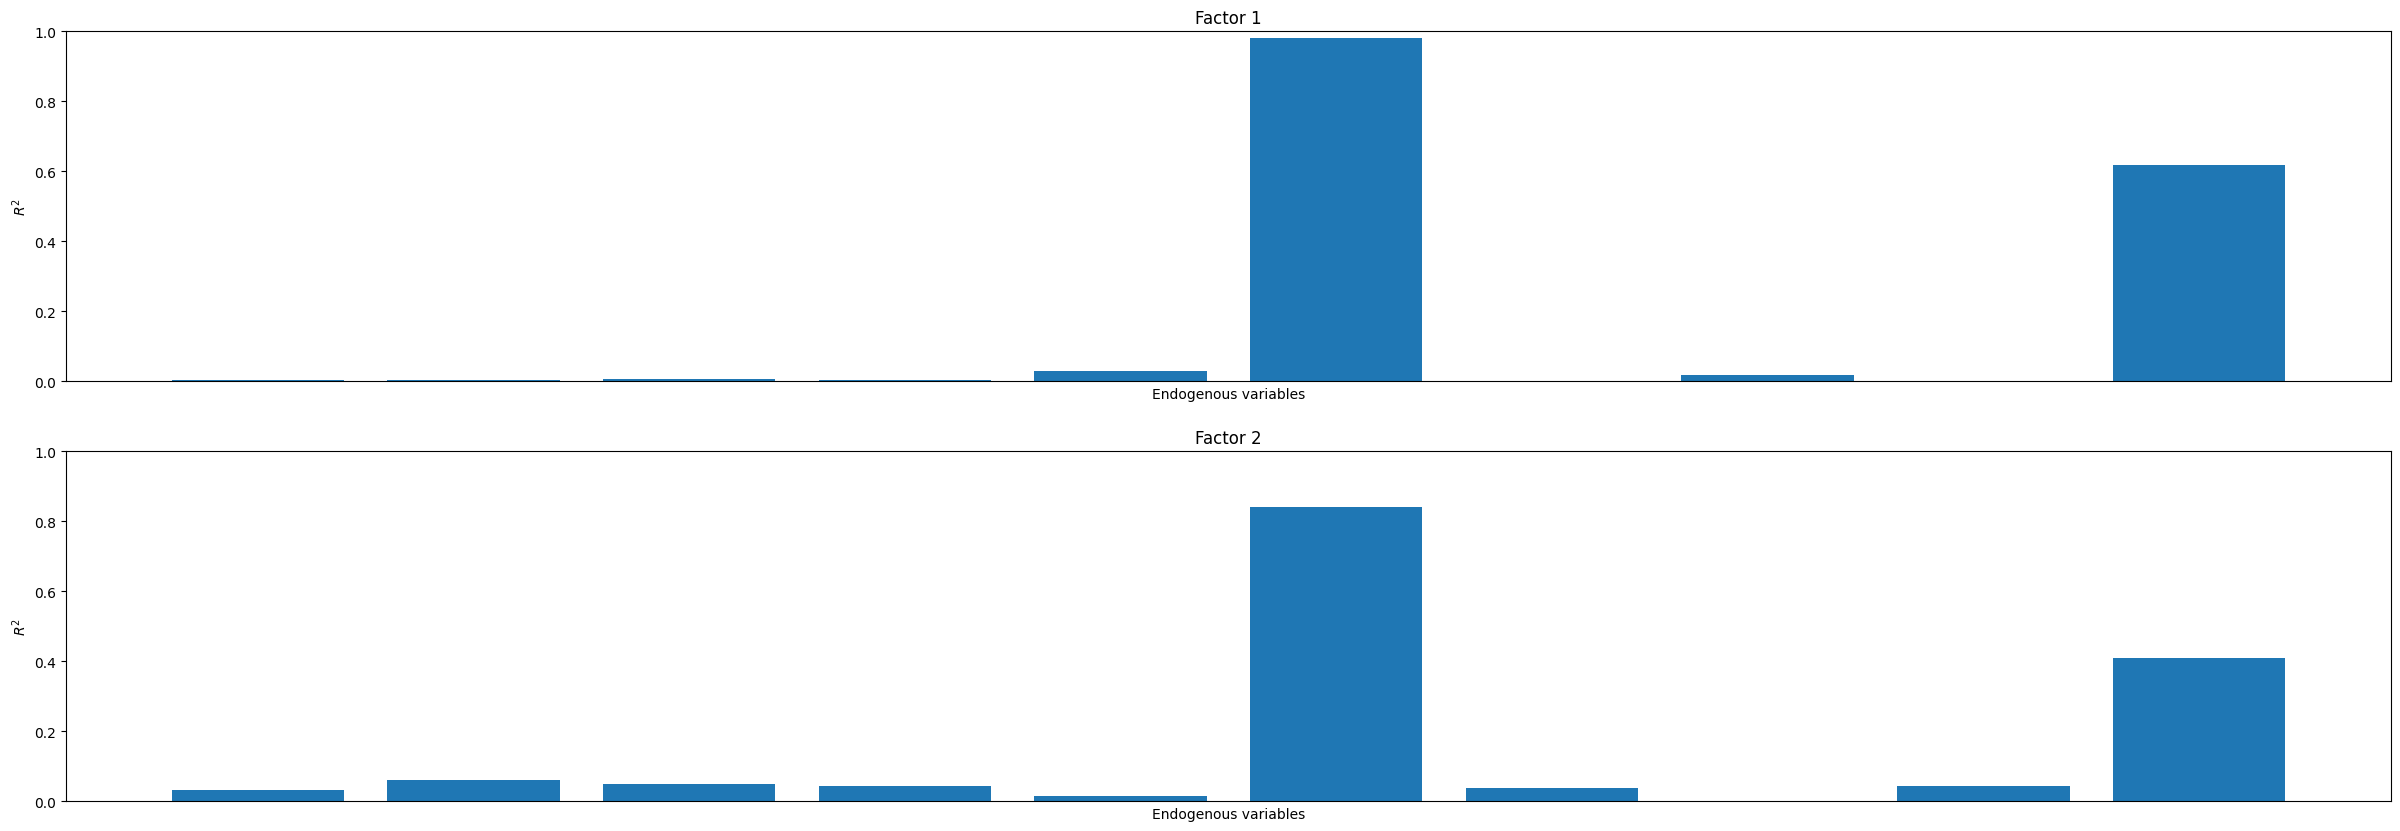

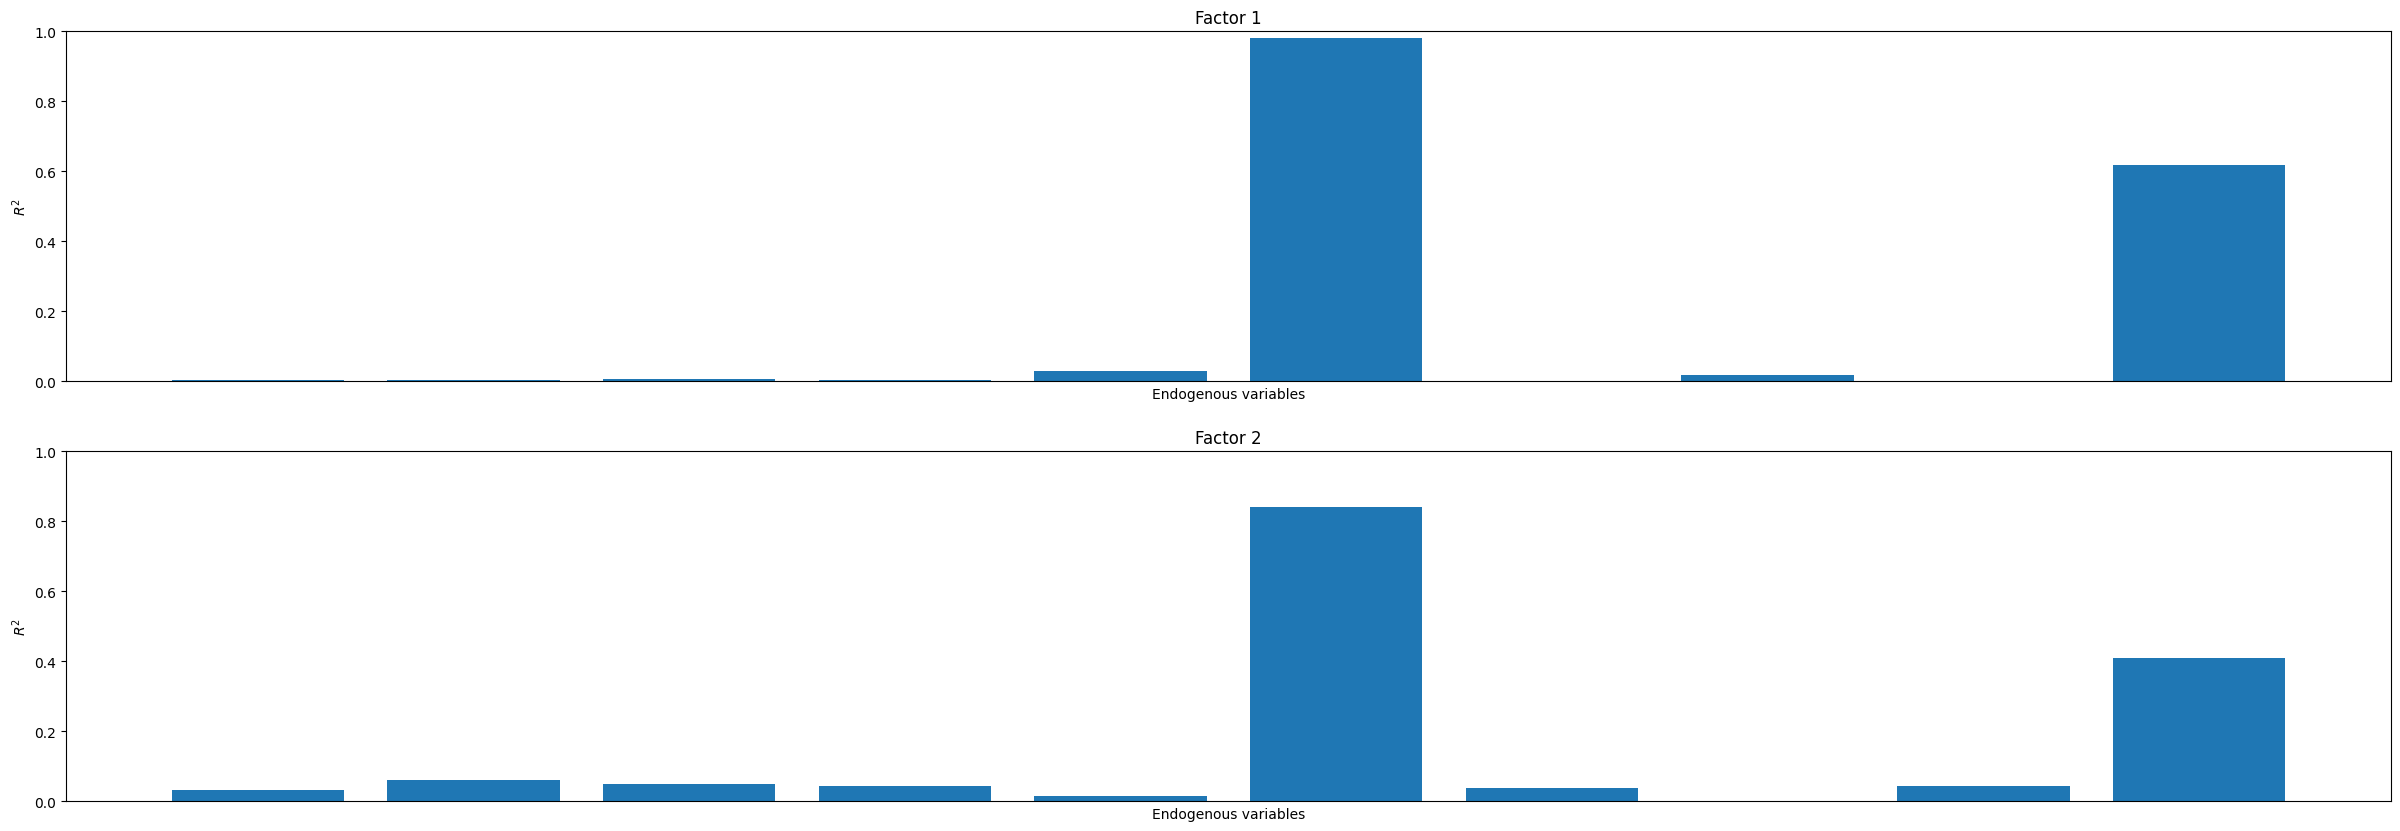

In [34]:
res2.plot_coefficients_of_determination(figsize=(30,10))